In [87]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

from joblib import Parallel, delayed

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge

In [2]:
DATA_DIR = "../data"

In [3]:
!ls "../data"

sample_submission.csv  train.csv              train_split_master.csv
test                   train.hdf
test.zip               train_split


In [4]:
train_split_master = pd.read_csv(os.path.join(DATA_DIR, "train_split_master.csv"))

In [5]:
#train_split_master[(train_split_master["data_length"]==150_000) & (train_split_master["head_eq_num"] == train_split_master["tail_eq_num"])].iloc[4120:, :]

In [6]:
#train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
train_df = pd.read_hdf(os.path.join(DATA_DIR, "train.hdf"))

In [7]:
# Create a training file with simple derived features
rows = 150_000
segments = int(np.floor(train_df.shape[0] / rows))
print(segments)

4194


In [8]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [9]:
def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

In [25]:
def feature_engineering_basic(x):
    x_abs = np.abs(x)
    x_max = x.max()
    x_min = x.min()
    
    X_features = pd.Series(dtype=np.float64)
    
    X_features.loc['mean'] = x.mean()
    X_features.loc['std'] = x.std()
    X_features.loc['max'] = x_max
    X_features.loc['min'] = x_min
    X_features.loc['mad'] = x.mad()
    X_features.loc['kurt'] = x.kurtosis()
    X_features.loc['skew'] = x.skew()
#     X_features.loc['med'] = x.median()
    
    X_features.loc['max_to_min'] = x_max / np.abs(x_min)
    X_features.loc['max_to_min_diff'] = x_max - np.abs(x_min)
    X_features.loc['max_min_diff'] = x_max - x_min
#     X_features.loc['count_big'] = len(x[x_abs > 500])
    
    X_features.loc['mean_change_abs'] = np.mean(np.diff(x))
    X_features.loc['mean_change_rate'] = calc_change_rate(x)
    X_features.loc['abs_max'] = x_abs.max()
    X_features.loc['abs_min'] = x_abs.min()
        
    X_features.loc['mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    X_features.loc['mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X_features.loc['mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    X_features.loc['mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    X_features.loc['q999'] = np.quantile(x,0.999)
    X_features.loc['q99'] = np.quantile(x, 0.99)
    X_features.loc['q95'] = np.quantile(x, 0.95)
    X_features.loc['q05'] = np.quantile(x, 0.05)
    X_features.loc['q01'] = np.quantile(x, 0.01)
    X_features.loc['q001'] = np.quantile(x,0.001)
    
#     X_features.loc['abs_q95'] = np.quantile(x_abs, 0.95)
#     X_features.loc['abs_q99'] = np.quantile(x_abs, 0.99)
#     X_features.loc['abs_q05'] = np.quantile(x_abs, 0.05)
#     X_features.loc['abs_q01'] = np.quantile(x_abs, 0.01)
    
    X_features.loc['trend'] = add_trend_feature(x)
    X_features.loc['abs_trend'] = add_trend_feature(x_abs)
    X_features.loc['abs_mean'] = x_abs.mean()
    X_features.loc['abs_std'] = x_abs.std()
        
#     X_features.loc['Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_features.loc['Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_features.loc['classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_features.loc['classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_features.loc['classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_features.loc['classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_features.loc['classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X_features.loc['classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X_features.loc['classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X_features.loc['classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    
#     no_of_std = 3
#     X_features.loc['Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
#     X_features.loc['MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
#     X_features.loc['MA_700MA_BB_highf_mean'] = (X_features.loc['Moving_average_700_mean'] + no_of_std * X_features.loc['MA_700MA_std_mean']).mean()
#     X_features.loc['MA_700MA_BB_low_mean'] = (X_features.loc['Moving_average_700_mean'] - no_of_std * X_features.loc['MA_700MA_std_mean']).mean()
#     X_features.loc['MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
#     X_features.loc['MA_400MA_BB_high_mean'] = (X_features.loc['Moving_average_700_mean'] + no_of_std * X_features.loc['MA_400MA_std_mean']).mean()
#     X_features.loc['MA_400MA_BB_low_mean'] = (X_features.loc['Moving_average_700_mean'] - no_of_std * X_features.loc['MA_400MA_std_mean']).mean()
#     X_features.loc['MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
#     X_features.drop('Moving_average_700_mean', inplace=True)
    
    X_features.loc['iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_features.loc['ave10'] = stats.trim_mean(x, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_features.loc['ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_features.loc['std_roll_std_' + str(windows)] = x_roll_std.std()
        X_features.loc['max_roll_std_' + str(windows)] = x_roll_std.max()
        X_features.loc['min_roll_std_' + str(windows)] = x_roll_std.min()
        X_features.loc['q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_features.loc['q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_features.loc['q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_features.loc['q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_features.loc['av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_features.loc['av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_features.loc['abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_features.loc['ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_features.loc['std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_features.loc['max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_features.loc['min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_features.loc['q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_features.loc['q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_features.loc['q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_features.loc['q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_features.loc['av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_features.loc['av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_features.loc['abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
        
    return X_features

In [64]:
def feature_engineering_window(x):
    X_features = pd.Series(dtype=np.float64)
    
    for start, window in [(0, 50000), (50000, 50000), (100000, 150000), 
                          (0, 10000), (10000, 10000), (20000, 10000), (30000, 10000), (110000, 10000), (120000, 10000), (130000, 10000) ,(140000, 10000), 
                          (0, 5000), (5000, 5000), (10000, 5000), (15000, 5000), (130000, 5000), (135000, 5000), (140000, 5000) ,(145000, 5000),]:
        X_features.loc[f'std_{start}_{window}'] = x[start:start+window].std()
        X_features.loc[f'avg_{start}_{window}'] = x[start:start+window].mean()
        X_features.loc[f'max_{start}_{window}'] = x[start:start+window].max()
        X_features.loc[f'min_{start}_{window}'] = x[start:start+window].min()

    return X_features

In [65]:
def get_train_valid_index(val_eq_nums=[13,14,15,16]):
    train_file_index = []
    val_file_index = []
    
    for segment in tqdm_notebook(train_split_master["file_number"]):
        if train_split_master.loc[segment, "data_length"] != 150_000 or train_split_master.loc[segment, "head_eq_num"] != train_split_master.loc[segment, "tail_eq_num"]:
            print("skipped : file_num=", segment)
            continue
        
        if train_split_master.loc[segment, "head_eq_num"] in val_eq_nums:
            val_file_index.append(segment)
        else:
            train_file_index.append(segment)
    
    return train_file_index, val_file_index

def get_train_index():
    train_file_index = []
    
    for segment in tqdm_notebook(train_split_master["file_number"]):
        if train_split_master.loc[segment, "data_length"] != 150_000 or train_split_master.loc[segment, "head_eq_num"] != train_split_master.loc[segment, "tail_eq_num"]:
            print("skipped : file_num=", segment)
            continue
        
        train_file_index.append(segment)
    
    return train_file_index

In [28]:
#train_file_index, val_file_index = get_train_valid_index()
train_file_index = get_train_index()

skipped : file_num= 37
skipped : file_num= 333
skipped : file_num= 697
skipped : file_num= 925
skipped : file_num= 1250
skipped : file_num= 1457
skipped : file_num= 1638
skipped : file_num= 2052
skipped : file_num= 2255
skipped : file_num= 2502
skipped : file_num= 2795
skipped : file_num= 3078
skipped : file_num= 3305
skipped : file_num= 3525
skipped : file_num= 3903
skipped : file_num= 4146
skipped : file_num= 4194



In [29]:
len(train_file_index), train_file_index[:5]

(4178, [0, 1, 2, 3, 4])

In [34]:
def process(segment, process_func):
    # load data
    seg = pd.read_csv(os.path.join(DATA_DIR, "train_split", "train_"+str(segment)+".csv"))

    # set data
    data = pd.DataFrame(columns=[segment], dtype=np.float64)
    data[segment] = process_func(seg['acoustic_data'])
    data.loc["time_to_failure", segment] = seg['time_to_failure'].values[-1]    
    return data

def make_input_dataset(index_list, process_func):
    res_list = Parallel(n_jobs=-1, verbose=5)([delayed(process)(seg_id, process_func) for seg_id in index_list])
    data_X = pd.concat(res_list, axis=1).T
    data_y = data_X[["time_to_failure"]]
    data_X = data_X.drop(["time_to_failure"], axis=1)
    
    return data_X, data_y

In [35]:
X_tr_basic, y_tr_basic = make_input_dataset(train_file_index, feature_engineering_basic)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

In [36]:
X_tr_basic.shape

(4178, 105)

In [66]:
X_tr_window, _ = make_input_dataset(train_file_index, feature_engineering_window)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

In [67]:
X_tr_window.shape

(4178, 76)

In [68]:
X_tr = pd.concat([X_tr_basic, X_tr_window], axis=1)
y_tr = y_tr_basic

In [70]:
print(X_tr.shape)
X_tr.head()

(4178, 181)


,mean,std,max,min,mad,kurt,skew,max_to_min,max_to_min_diff,max_min_diff,...,max_135000_5000,min_135000_5000,std_140000_5000,avg_140000_5000,max_140000_5000,min_140000_5000,std_145000_5000,avg_145000_5000,max_145000_5000,min_145000_5000
0,4.884113333333334,5.101106130606765,104.0,-98.0,3.263401356800000,33.662481293451094,-0.024061166628209,1.061224489795918,6.0,202.0,...,19.0,-11.0,5.089376338049886,4.4622,26.0,-16.0,3.471986454176859,4.8890,23.0,-14.0
1,4.725766666666667,6.588823781946801,181.0,-154.0,3.574301851111111,98.758517178736923,0.390560504371834,1.175324675324675,27.0,335.0,...,38.0,-25.0,4.165044028380933,4.8576,29.0,-24.0,3.091194212004685,4.9712,15.0,-8.0
2,4.906393333333333,6.967397033524431,140.0,-106.0,3.948411362133333,33.555211406928983,0.217390561445685,1.320754716981132,34.0,246.0,...,105.0,-89.0,11.077903539450318,5.2154,95.0,-71.0,7.587302761366422,5.1468,61.0,-63.0
3,4.902240000000000,6.922305187180113,197.0,-199.0,3.647117068800000,116.548171687628383,0.757277536411098,0.989949748743719,-2.0,396.0,...,27.0,-19.0,5.295870928353330,5.3006,35.0,-36.0,3.165633094118350,5.0444,18.0,-8.0
4,4.908720000000000,7.301110189758817,145.0,-126.0,3.826051623466666,52.977904834406473,0.064531069271374,1.150793650793651,19.0,271.0,...,15.0,-5.0,15.338529691551917,4.6190,128.0,-126.0,4.988283531889392,4.7980,49.0,-24.0


In [73]:
np.abs(X_tr.corrwith(y_tr["time_to_failure"])).sort_values(ascending=False).head(20)

q05_roll_std_100                0.646649148129883
q01_roll_std_100                0.642577426128159
q05_roll_std_10                 0.641115991610930
q01_roll_std_10                 0.633299355927607
q05_roll_std_1000               0.612340878174819
q01_roll_std_1000               0.601550321234658
classic_sta_lta5_mean           0.578273039982741
min_roll_std_1000               0.542092726433172
mean_change_rate                0.536630028584792
classic_sta_lta7_mean           0.513894770852388
mean_change_rate_last_50000     0.506507216360353
mean_change_rate_first_50000    0.506070363145635
iqr                             0.504569517089761
classic_sta_lta6_mean           0.439691114166279
q95_roll_std_10                 0.438006689125785
q95_roll_mean_10                0.437773862616008
q95_roll_std_100                0.431918463980344
q05_roll_mean_10                0.427200386902132
q95_roll_std_1000               0.425054581171952
q95                             0.421772962438249


In [74]:
means_dict = {}
for col in X_tr.columns:
    if X_tr[col].isnull().any():
        print(col)
        mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
        X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
        X_tr[col] = X_tr[col].fillna(mean_value)
        means_dict[col] = mean_value

In [75]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

### Prepare test data

In [76]:
# basic feature
def process_test(segment, process_func):
    # load data
    seg = pd.read_csv(os.path.join(DATA_DIR, 'test/' + str(segment) + '.csv'))

    # set data
    data = pd.DataFrame(columns=[segment], dtype=np.float64)
    data[segment] = process_func(seg['acoustic_data'])

    return data

submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='seg_id')

In [50]:
res_list = Parallel(n_jobs=-1, verbose=5)([delayed(process_test)(seg_id, feature_engineering_basic) for seg_id in submission.index])
X_test_basic = pd.concat(res_list, axis=1).T

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2624 out of 2624 | elapsed:  2.9min finished


In [77]:
res_list = Parallel(n_jobs=-1, verbose=5)([delayed(process_test)(seg_id, feature_engineering_window) for seg_id in submission.index])
X_test_window = pd.concat(res_list, axis=1).T

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 1716 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 2256 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 2624 out of 2624 | elapsed:   59.2s finished


In [78]:
X_test = pd.concat([X_test_basic, X_test_window], axis=1)

In [79]:
print(X_test.shape)
X_test.head()

(2624, 181)


,mean,std,max,min,mad,kurt,skew,max_to_min,max_to_min_diff,max_min_diff,...,max_135000_5000,min_135000_5000,std_140000_5000,avg_140000_5000,max_140000_5000,min_140000_5000,std_145000_5000,avg_145000_5000,max_145000_5000,min_145000_5000
seg_00030f,4.491780000000000,4.893689687028083,115.0,-75.0,3.248521054133333,28.837568099164539,0.327907635264522,1.533333333333333,40.0,190.0,...,42.0,-31.0,7.781935359766793,4.1876,43.0,-37.0,3.448636231667769,4.3474,22.0,-13.0
seg_0012b5,4.171153333333334,5.922839443206501,152.0,-140.0,3.429208497866667,56.218954550493322,0.295707859154105,1.085714285714286,12.0,292.0,...,14.0,-6.0,4.085083967583095,4.3216,40.0,-19.0,3.038794776673632,3.9354,15.0,-9.0
seg_00184e,4.610260000000000,6.946990077499337,248.0,-193.0,3.461984010666667,162.118283628401656,0.428688288294736,1.284974093264249,55.0,441.0,...,16.0,-6.0,3.146900792354183,4.8140,19.0,-8.0,2.974635697275601,4.6404,18.0,-7.0
seg_003339,4.531473333333333,4.114146602958790,85.0,-93.0,2.678502757955556,41.241827462130018,0.061889362911379,0.913978494623656,-8.0,178.0,...,14.0,-5.0,2.798412654108850,4.4222,15.0,-7.0,2.743241716477606,4.5114,14.0,-5.0
seg_0042cc,4.128340000000000,5.797163636219714,177.0,-147.0,3.283855587733334,79.539707613111105,0.073898350757301,1.204081632653061,30.0,324.0,...,38.0,-28.0,8.880212364258350,4.2800,72.0,-79.0,3.946856812165745,4.2822,37.0,-20.0


In [80]:
for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])
        
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Learning

In [81]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [82]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
        print('\n' + '-'*30 + '\n')

    prediction /= n_fold
    
    print('\n' + '-'*60 + '\n' + '-'*60 + '\n')
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
#             cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
#                 by="importance", ascending=False)[:50].index

#             best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

#             plt.figure(figsize=(16, 12));
#             sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
#             plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [88]:
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'regression_l1',
          'max_depth': -1,
          'learning_rate': 0.004,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }

In [89]:
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Mon Apr 29 18:47:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1364]	training's l1: 1.49039	valid_1's l1: 2.03119

------------------------------

Fold 1 started at Mon Apr 29 18:47:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1222]	training's l1: 1.53521	valid_1's l1: 2.05282

------------------------------

Fold 2 started at Mon Apr 29 18:47:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2267]	training's l1: 1.32493	valid_1's l1: 2.1253

------------------------------

Fold 3 started at Mon Apr 29 18:47:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[801]	training's l1: 1.68252	valid_1's l1: 1.88897

------------------------------

Fold 4 started at Mon Apr 29 18:47:46 2019
Training until validation scores don't improve for 200 

Text(0.5,1,'lgb')

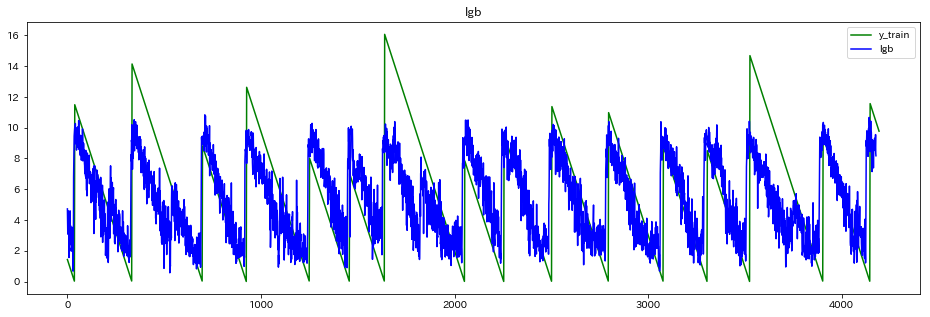

In [90]:
# check validation resulut
plt.figure(figsize=(16, 5))
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb, color='b', label='lgb')
plt.legend()
plt.title('lgb')

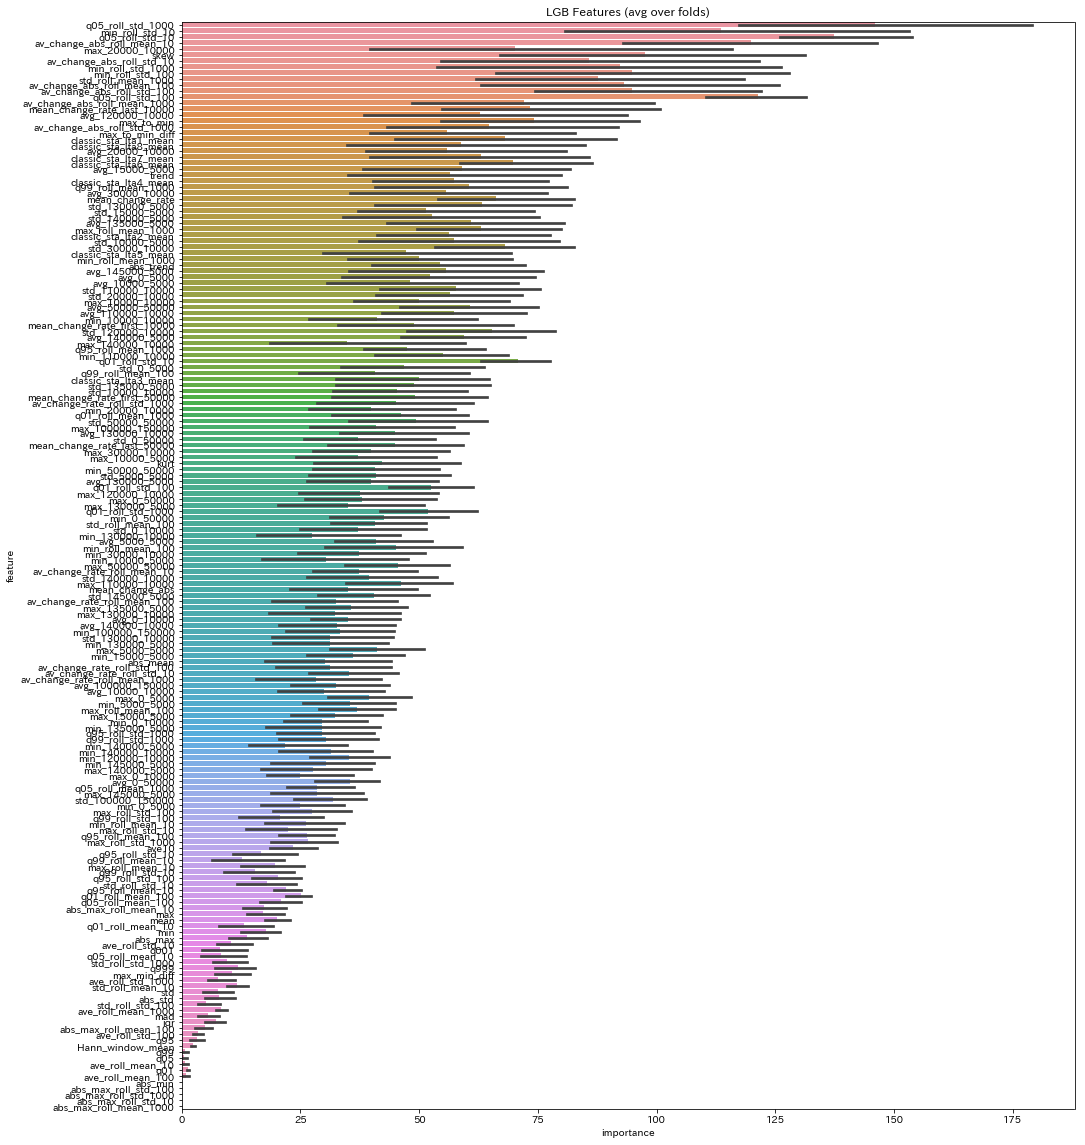

In [91]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False).index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 20));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

In [59]:
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.004,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mse'#'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }

Fold 0 started at Mon Apr 29 16:45:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2935]	training's l1: 1.58346	valid_1's l1: 2.03541

------------------------------

Fold 1 started at Mon Apr 29 16:45:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2695]	training's l1: 1.62746	valid_1's l1: 2.03094

------------------------------

Fold 2 started at Mon Apr 29 16:45:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[3478]	training's l1: 1.48295	valid_1's l1: 2.11428

------------------------------

Fold 3 started at Mon Apr 29 16:46:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2180]	training's l1: 1.74528	valid_1's l1: 1.90033

------------------------------

Fold 4 started at Mon Apr 29 16:46:22 2019
Training until validation scores don't improve for 20

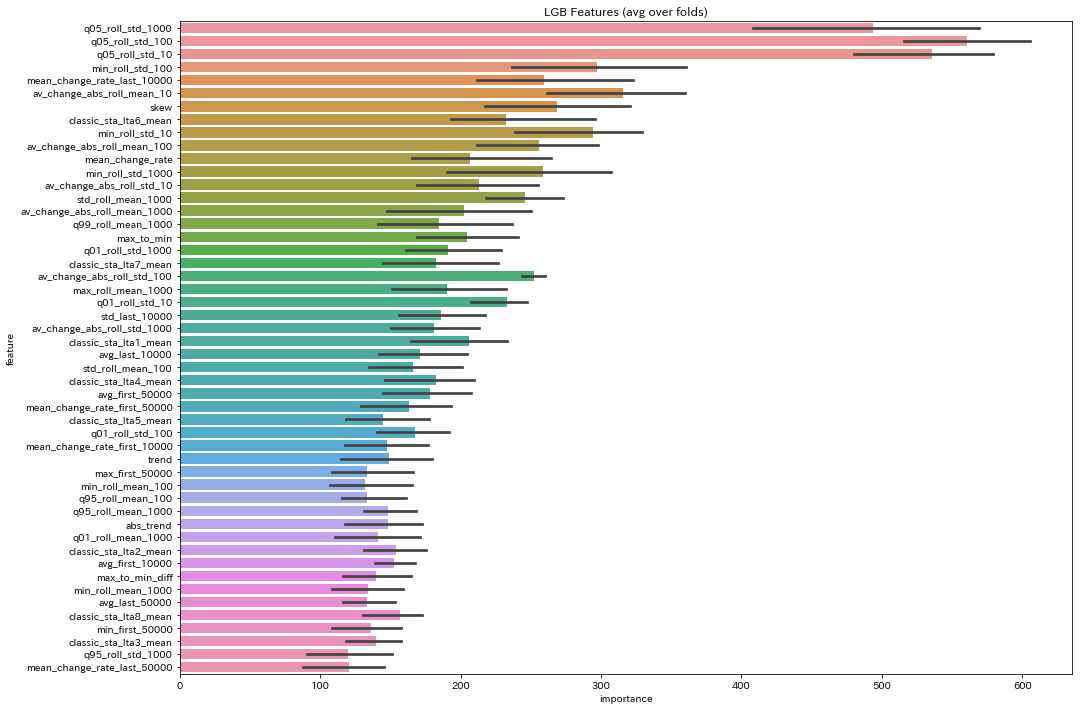

In [63]:
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)

Text(0.5,1,'lgb')

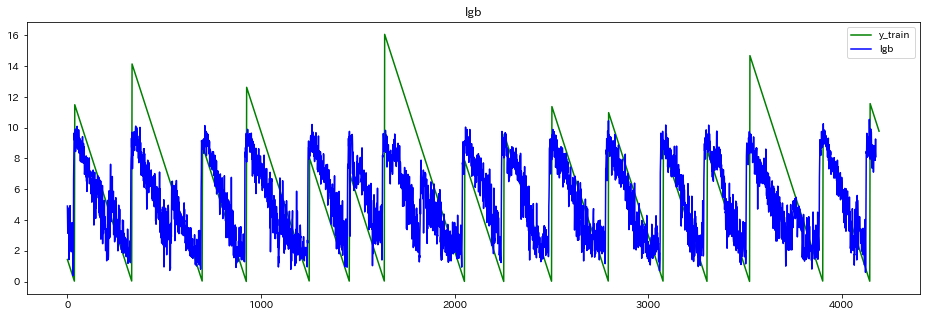

In [69]:
# check validation resulut
plt.figure(figsize=(16, 5))
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb, color='b', label='lgb')
plt.legend()
plt.title('lgb')

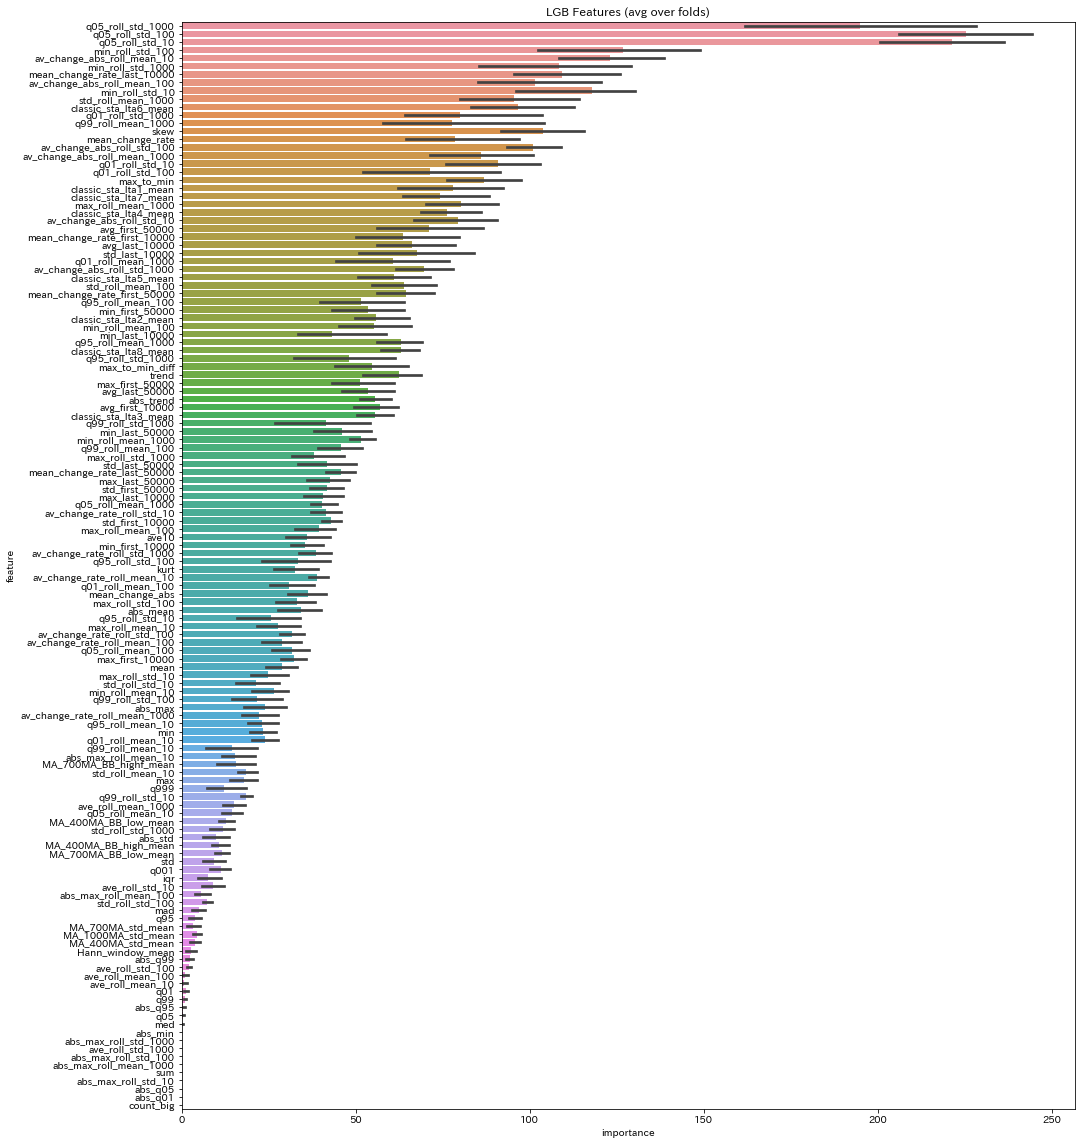

In [40]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False).index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 20));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

## Submission

In [92]:
submission['time_to_failure'] = prediction_lgb
# submission['time_to_failure'] = prediction_lgb_stack

submission.head()

,time_to_failure
seg_id,
seg_00030f,2.891852338185410
seg_0012b5,4.992295010060896
seg_00184e,6.043884907670083
seg_003339,7.634513214737238
seg_0042cc,6.419307299552054


In [94]:
submission.to_csv(os.path.join("../submission", "kernel_copy_submission.csv"))